In [108]:
from block_bootstrap_simulation_1v import run_bootstrap_simulation_single
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [109]:
data = pd.read_csv("../data/processed/tmax2m_sp_point.csv", parse_dates=["date"])
data = data.set_index("date")

y = data['tmax2m'].values
y = y - np.nanmean(y)

n = len(y)
autocorr = np.array([np.corrcoef(y[:-lag], y[lag:])[0,1] for lag in range(1, n//2)])

weights = 1 - np.arange(1, len(autocorr)+1) / len(autocorr)
T0 = 1 + 2 * np.sum(weights * autocorr)

print("T0 (en días):", T0)

block_size = int(np.ceil(T0))
print("Tamaño de bloque sugerido (días):", block_size)

T0 (en días): 2.1859190434837874
Tamaño de bloque sugerido (días): 3


In [110]:
n_simulations = 1000
window_days = 10
results_dir = '../data/processed/bootstrap_tmax2m/'

run_bootstrap_simulation_single(
    data=data,
    variable="tmax2m",
    n_simulations=n_simulations,
    block_length=block_size,
    window_days=window_days,
    output_dir=results_dir
)

100%|██████████| 1000/1000 [00:00<00:00, 420313.06it/s]

✅ Completed 1000 simulations for tmax2m


In [111]:
aep_temp = pd.read_csv(f'{results_dir}aep_curve_tmax2m.csv')
sim_daily_temp = pd.read_csv(f'{results_dir}daily_simulations_tmax2m.csv')
summary_stats = pd.read_csv(f'{results_dir}summary_stats_tmax2m.csv')


In [112]:
n_sims = len([col for col in sim_daily_temp.columns if col.startswith('sim_')])

sim_dfs = []

for i in range(n_sims):
    sim_num = f'{i:04d}'
    temp_col = f'sim_{sim_num}'
    sim_data = pd.DataFrame({
        'temperature': sim_daily_temp[temp_col]
    })
    sim_data['simulation'] = i
    sim_dfs.append(sim_data)

sim_df_reshaped = pd.concat(sim_dfs, axis=0).reset_index(drop=True)


In [ ]:
fraction_brave_riders = 0.6
fraction_hw_wage = 3

total_riders = 20000
normal_wage = 1

brave_riders = int(total_riders * fraction_brave_riders)
no_brave_riders = total_riders - brave_riders

hw_wage = normal_wage * fraction_hw_wage

daily_loss = np.abs(total_riders * normal_wage - (brave_riders * hw_wage))

threshold_temperature = 32
print("threshold_temp:", threshold_temperature)

sim_df_reshaped['cond_temp'] = (sim_df_reshaped['temperature'] > threshold_temperature).astype(int)

def _mark_runs(series, min_len=3):
    cond = series.astype(bool)
    runs = (cond != cond.shift()).cumsum()
    run_sizes = cond.groupby(runs).transform('size')
    return ((cond) & (run_sizes >= min_len)).astype(int)

sim_df_reshaped['event'] = sim_df_reshaped.groupby('simulation', group_keys=False)['cond_temp'].apply(_mark_runs)
sim_df_reshaped['loss'] = daily_loss * sim_df_reshaped['event']

total_dias = len(sim_df_reshaped)
frac_event = sim_df_reshaped['event'].sum() / total_dias
print(f"Porcentaje de días con evento: {frac_event:.2%}")

sim_df_reshaped['day_of_year'] = np.tile(np.arange(1, 366), len(sim_df_reshaped['simulation'].unique()))

# de noviembre a marzo incluido
summer_days = list(range(305, 366)) + list(range(1, 91))
sim_df_summer = sim_df_reshaped[sim_df_reshaped['day_of_year'].isin(summer_days)].copy()

sim_df_summer['cond_temp_summer'] = (sim_df_summer['temperature'] > threshold_temperature).astype(int)
sim_df_summer['event_summer'] = sim_df_summer.groupby('simulation', group_keys=False)['cond_temp_summer'].apply(_mark_runs)
sim_df_summer['loss_summer'] = daily_loss * sim_df_summer['event_summer']

total_days_summer = len(sim_df_summer)
frac_event_summer = sim_df_summer['event_summer'].sum() / total_days_summer
print(f"Porcentaje de días con evento (verano): {frac_event_summer:.2%}")


threshold_temp: 32
Porcentaje de días con evento: 1.21%
Porcentaje de días con evento (verano): 1.49%


In [ ]:
summary_by_sim = sim_df_reshaped.groupby('simulation').agg({
    'event': 'sum',
    'loss': 'sum'
})

summary_stats = summary_by_sim.mean().to_frame("Media")
summary_stats["Mediana"] = summary_by_sim.median()
summary_stats["Máximo"] = summary_by_sim.max()
summary_stats["Mínimo"] = summary_by_sim.min()

print("\nPromedio de eventos y pérdidas anuales por simulación:")
print(summary_stats)



Promedio de eventos y pérdidas anuales por simulación:
           Media  Mediana  Máximo  Mínimo
event      4.404      3.0      20       0
loss   70464.000  48000.0  320000       0


In [ ]:
# --- Curva AEP usando "loss" ---
def build_aep(loss_series, label):
    s = loss_series.sort_values(ascending=False).reset_index(drop=True)
    n = len(s)
    ex_prob = [(i)/(n+1)*100 for i in range(1, n+1)]    # 100/(n+1) es la probabilidad de excedencia
    return pd.DataFrame({'Loss': s, 'Exceedance_Probability': ex_prob, 'Type': label})

aep_temp = build_aep(summary_by_sim['loss'], 'event')


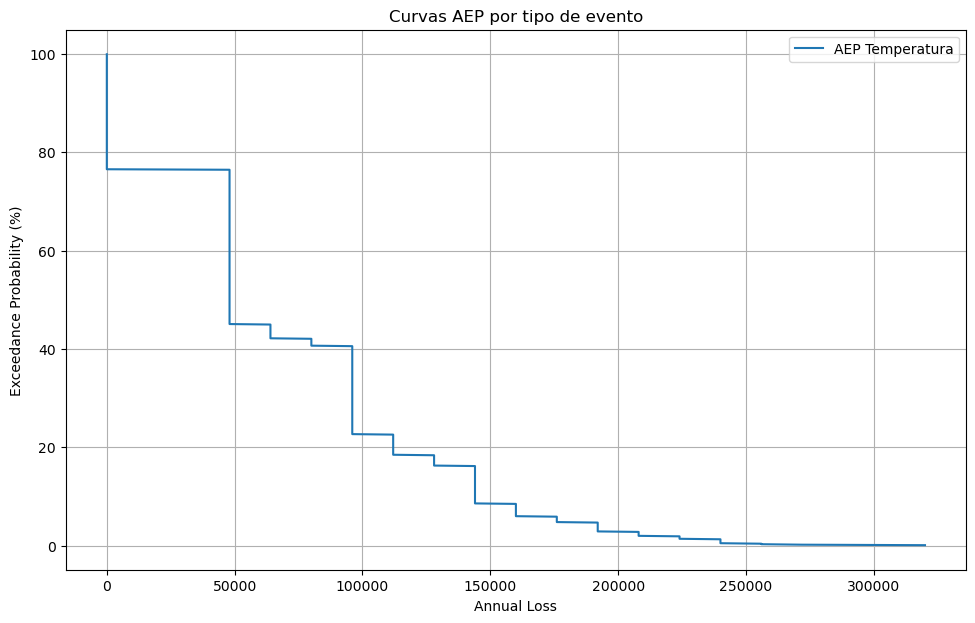

In [ ]:
fig = plt.figure(figsize=(10,6))
ax = plt.axes([0.05, 0.05, 0.9, 0.9])
ax.plot(aep_temp['Loss'], aep_temp['Exceedance_Probability'], label="AEP Temperatura")
ax.grid(True)
ax.set_ylabel('Exceedance Probability (%)')
ax.set_xlabel('Annual Loss')
ax.set_title('Curvas AEP por tipo de evento')
ax.legend()
